In [1]:
#Import general libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Import libraries useful for building the pipeline and join their branches
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
#import modules created for data preparation phase
import my_utils
import missing_val_imput
import feature_select
import preprocessing
import adhoc_transf
#import libraries for data preparation phase
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
#import libraries from modelling phase
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
#import classifiers
#import Ensemble Trees Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier,VotingClassifier
import xgboost as xgb
#to save model fit with GridSearchCV and avoid longer waits
import joblib

c:\Users\xdpemo\Anaconda3\envs\XAI-HF\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
c:\Users\xdpemo\Anaconda3\envs\XAI-HF\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
###########################################################################
#  Explainability Analisys
# The "most explainable" classifier is ExtraTrees by assessing the FIR ratio
# Different explainability method are considered: implicit feature importance, feature permutation, SHAP and PDP
###########################################################################
#Loading the dataset
path_data=r'C:\Users\xdpemo\OneDrive - TUNI.fi\Documents\GitHub\Heart_Failure_Predictor\heart_failure_clinical_records_dataset.csv'
df=pd.read_csv(path_data)
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [3]:
#%%
###################################################################################################################
##Step 1.1 Winsorization strategies to set the outliers to the values of 10 and 90 percentiles
####################################################################


def winsorize_percentiles(df, columns, lower_percentile, upper_percentile):
    for column in columns:
        lower_limit = df[column].quantile(lower_percentile/100)
        upper_limit = df[column].quantile(upper_percentile/100)
        df[column] = df[column].clip(lower_limit, upper_limit)
    return df

# Example usage

columns_to_winsorize = ['creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium',]
lower_percentile = 0
upper_percentile = 90

df = winsorize_percentiles(df, columns_to_winsorize, lower_percentile, upper_percentile)

In [4]:
target_feature='DEATH_EVENT'
numerical_feats=['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']
nominal_feats=['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
df=adhoc_transf.ageRounder().fit_transform(df)
my_utils.df_values(df)


>>>>>>>>Calling init() from ageRounder

>>>>>>>>Calling fit() from ageRounder

>>>>>>>>Calling transform() from ageRounder

>>>>>>>>Calling rounder
*****start of feature  age *************************
60.0    33
50.0    27
65.0    26
70.0    25
45.0    19
55.0    17
75.0    11
58.0    10
53.0    10
63.0     8
42.0     7
40.0     7
72.0     7
80.0     7
61.0     6
85.0     6
52.0     5
68.0     5
62.0     5
49.0     4
59.0     4
73.0     4
51.0     4
64.0     3
46.0     3
69.0     3
82.0     3
90.0     3
66.0     2
78.0     2
54.0     2
77.0     2
57.0     2
44.0     2
67.0     2
95.0     2
48.0     2
43.0     1
86.0     1
81.0     1
79.0     1
41.0     1
94.0     1
87.0     1
47.0     1
56.0     1
Name: age, dtype: int64
*****end of feature  age ************************** 

*****start of feature  anaemia *************************
0    170
1    129
Name: anaemia, dtype: int64
*****end of feature  anaemia ************************** 

*****start of feature  creatinine_phosphokinase *****

In [5]:
###################################################################################################################
#Step 1 Solving wrong characters of dataset
###################################################################################################################
#Performing numeric cast for numerical features
df.loc[:,numerical_feats]=adhoc_transf.Numeric_Cast_Column().fit_transform(df.loc[:,numerical_feats])
df[numerical_feats].dtypes
#Performing category cast for nominal features
df.loc[:,nominal_feats]=adhoc_transf.Category_Cast_Column().fit_transform(df.loc[:,nominal_feats])
df[nominal_feats].dtypes


>>>>>>>>Calling init() from Numeric_Cast_Column

>>>>>>>>Calling fit() from Numeric_Cast_Column

>>>>>>>>Calling transform() from Numeric_Cast_Column

>>>>>>>>Calling init() from Category_Cast_Column

>>>>>>>>Calling fit() from Category_Cast_Column

>>>>>>>>Calling transform() from Category_Cast_Column


anaemia                category
diabetes               category
high_blood_pressure    category
sex                    category
smoking                category
dtype: object

In [6]:
###################################################################################################################
##Step 2 Train-Test splitting
###################################################################################################################
#Split the dataset into train and test
test_ratio_split=0.3
train_set,test_set=train_test_split(df, test_size=test_ratio_split, random_state=42, stratify=df[target_feature])
X_train=train_set.drop(target_feature,axis=1)
y_train=train_set[target_feature].copy()
X_test=test_set.drop(target_feature,axis=1)
y_test=test_set[target_feature].copy()

In [7]:
###################################################################################################################
##Step 3 Label Encoding of target value
###################################################################################################################
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.fit_transform(y_test)
le.classes_

array([0, 1], dtype=int64)

In [8]:
###################################################################################################################
##Step 4 Building pipelines for data preparation
###################################################################################################################
#Lets define 3 pipeline mode
#a) parallel approach where feature selection is performed in parallel
# for numerical, nominal and categorical
#b) general approach where feature selection is performed as a whole for other features
#c) no feature selection is performed
#Before a data preprocessing will take place for each type of feature
pipeline_numeric_feat=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='median')),
('scaler', MinMaxScaler())])
pipeline_numeric_feat_mean=Pipeline([ ('data_missing',missing_val_imput.Numeric_Imputer(strategy='mean')),
('scaler', MinMaxScaler())])
pipeline_nominal_feat=Pipeline([('data_missing',missing_val_imput.Category_Imputer()),
('encoding', OrdinalEncoder())])#We dont use OneHotEncoder since it enlarges the number of nominal features
pipeline_ordinal_feat=Pipeline([ ('data_missing',missing_val_imput.Category_Imputer(strategy='most_frequent')),
('encoding', OrdinalEncoder())])
#option a)
pipe_numeric_featsel=Pipeline([('data_prep',pipeline_numeric_feat),
('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_nominal_featsel=Pipeline([('data_prep',pipeline_nominal_feat),
('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
pipe_ordinal_featsel=Pipeline([('data_prep',pipeline_ordinal_feat),
('feat_sel',feature_select.Feature_Selector(strategy='wrapper_RFECV') )])
dataprep_pipe_opta=ColumnTransformer([('numeric_pipe',pipe_numeric_featsel,numerical_feats),
('nominal_pipe',pipe_nominal_featsel,nominal_feats)
])


 Mon Jun  5 15:39:50 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 15:39:50 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 15:39:50 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 15:39:50 2023 >>>>>>>>Calling init() from Category_Imputer

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector

>>>>>>>>Calling init() from Feature_Selector


In [10]:
###################################################################################################################
##Step 5 Tailoring the dataset with the feature selected of the best classifier
###################################################################################################################
features_selected_xtree=['age','ejection_fraction','serum_creatinine','time','diabetes']
X_train_feat_sel=X_train[features_selected_xtree]
X_test_feat_sel=X_test[features_selected_xtree]
extratree_clf=ExtraTreesClassifier(random_state=42)

In [11]:
###################################################################################################################
##Step 6 The estimator is refited with those feature selected
#########################################################
numerical_feats_xtree=['age','ejection_fraction','serum_creatinine','time']
nominal_feats_xtree=['diabetes']
dataprep_merge_feat_xtree=ColumnTransformer([('numeric_pipe',pipeline_numeric_feat_mean,numerical_feats_xtree),
('nominal_pipe',pipeline_nominal_feat, nominal_feats_xtree)
])

In [12]:
X_train_featsel=dataprep_merge_feat_xtree.fit_transform(X_train_feat_sel)
df_X_train_featsel=pd.DataFrame(X_train_featsel, columns=features_selected_xtree)
df_X_train_featsel.head()


 Mon Jun  5 15:45:57 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 15:45:57 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 15:45:57 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 15:45:57 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 15:45:57 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 15:45:57 2023 >>>>>>>>Calling transform() from Category_Imputer


,age,ejection_fraction,serum_creatinine,time,diabetes
0,0.181818,0.777778,0.0625,0.613139,0.0
1,0.090909,0.222222,0.1875,0.824818,1.0
2,0.363636,0.777778,1.0000,0.302920,0.0
3,0.090909,0.444444,0.1875,0.427007,0.0
4,0.509091,1.000000,0.3125,0.850365,1.0


In [13]:
X_test_featsel=dataprep_merge_feat_xtree.fit_transform(X_test_feat_sel)
df_X_test_featsel=pd.DataFrame(X_test_featsel, columns=features_selected_xtree)
df_X_test_featsel.head()


 Mon Jun  5 15:46:01 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 15:46:01 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 15:46:01 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 15:46:01 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 15:46:01 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 15:46:01 2023 >>>>>>>>Calling transform() from Category_Imputer


,age,ejection_fraction,serum_creatinine,time,diabetes
0,0.218182,0.347826,0.066667,0.377698,0.0
1,0.327273,0.239130,0.466667,0.712230,0.0
2,0.636364,0.521739,1.000000,0.010791,0.0
3,0.000000,0.456522,0.333333,0.737410,0.0
4,0.454545,1.000000,0.200000,0.312950,1.0


In [14]:
extratree_clf.fit(df_X_train_featsel,y_train)

ExtraTreesClassifier(random_state=42)

In [15]:
###################################################################################################################
## Step 11 SHAP explainability
##############################################################
#global explainability
##################################################################
import shap
shap.initjs()
pipe_shap_xtree=Pipeline([('data_prep',dataprep_merge_feat_xtree),
('clf', extratree_clf)])
pipe_shap_xtree.fit(X_train_feat_sel, y_train)


 Mon Jun  5 15:46:15 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 15:46:15 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 15:46:15 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 15:46:15 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 15:46:15 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 15:46:15 2023 >>>>>>>>Calling transform() from Category_Imputer


Pipeline(steps=[('data_prep',
                 ColumnTransformer(transformers=[('numeric_pipe',
                                                  Pipeline(steps=[('data_missing',
                                                                   Numeric_Imputer(strategy='mean')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'ejection_fraction',
                                                   'serum_creatinine',
                                                   'time']),
                                                 ('nominal_pipe',
                                                  Pipeline(steps=[('data_missing',
                                                                   Category_Imputer()),
                                                                  ('encoding',
                             

In [16]:
explainer_train=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_train_feat_sel))
shap_values_train=explainer_train.shap_values(pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_train_feat_sel))


 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 15:46:22 2023 >>>>>>>>Calling transform() from Category_Imputer


In [17]:
# explainer=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_train_feat_sel))
# shap_values=explainer.shap_values(X_train_feat_sel)

In [18]:
np.shape(shap_values_train)

(2, 209, 5)

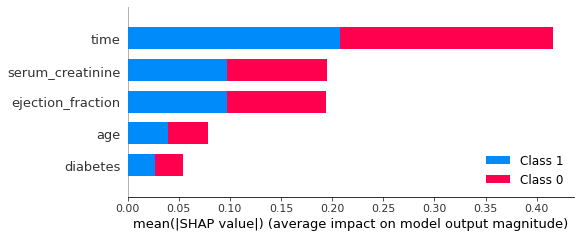

In [19]:
shap.summary_plot(shap_values_train, X_train_feat_sel,plot_type="bar")

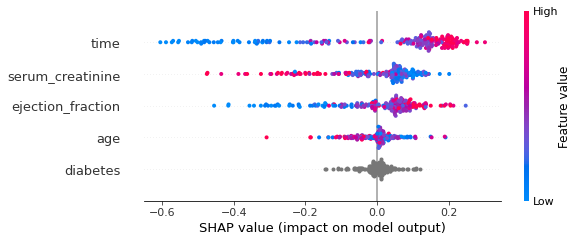

In [22]:
shap.summary_plot(shap_values_train[0], X_train_feat_sel,plot_type="dot")

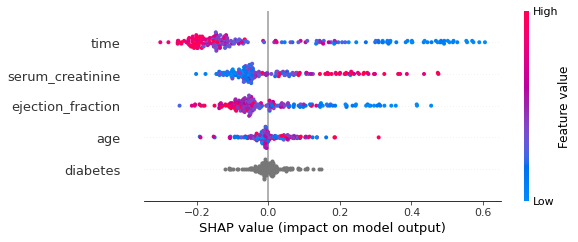

In [23]:
shap.summary_plot(shap_values_train[1], X_train_feat_sel,plot_type="dot")

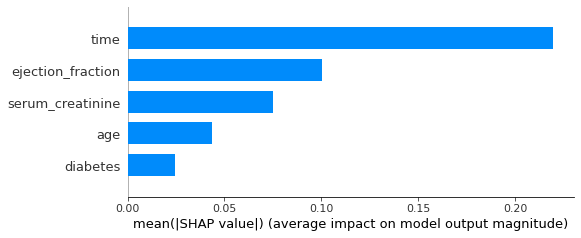

In [20]:
shap.summary_plot(shap_values_train[1], X_train_feat_sel,plot_type="bar")

In [21]:
X_train_feat_sel.head()

,age,ejection_fraction,serum_creatinine,time,diabetes
186,50.0,50,0.6,172,0
258,45.0,25,0.8,230,1
104,60.0,50,2.3,87,0
161,45.0,35,0.8,121,0
263,68.0,60,1.0,237,1


In [24]:
#local explainability
##########################################################
y_pred_test= extratree_clf.predict(df_X_test_featsel)
print('y_pred',y_pred_test)
print('y_test',y_test)

y_pred [0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1
 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1]
y_test [0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1
 0 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0]


In [25]:
y_pred_train = extratree_clf.predict(df_X_train_featsel)
print('y_pred_train',y_pred_train)
print('y_train',y_train)

y_pred_train [1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1
 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]
y_train [1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1
 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In [26]:
explainer_test=shap.explainers.Tree(pipe_shap_xtree.named_steps['clf'], pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_test_feat_sel))
shap_values_test=explainer_test.shap_values(pipe_shap_xtree.named_steps['data_prep'].fit_transform(X_test_feat_sel))


 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling transform() from Category_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling init() from Numeric_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling fit() from Numeric_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling transform() from Numeric_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling init() from Category_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling fit() from Category_Imputer

 Mon Jun  5 15:50:20 2023 >>>>>>>>Calling transform() from Category_Imputer


In [27]:
np.shape(shap_values_test)

(2, 90, 5)

In [28]:
#True negative instance
index_TN_shap=0
print(df_X_test_featsel.iloc[index_TN_shap])
print(X_test_feat_sel.iloc[index_TN_shap])
print('Actual Label:', y_test[index_TN_shap])
print('Predicted Label:', y_pred_test[index_TN_shap])
choosen_instance_tn=df_X_test_featsel.iloc[index_TN_shap]

age                  0.218182
ejection_fraction    0.347826
serum_creatinine     0.066667
time                 0.377698
diabetes             0.000000
Name: 0, dtype: float64
age                   52.0
ejection_fraction     30.0
serum_creatinine       0.7
time                 112.0
diabetes               0.0
Name: 146, dtype: float64
Actual Label: 0
Predicted Label: 0


In [29]:
shap_values_test_tn = explainer_test.shap_values(choosen_instance_tn)
shap.force_plot(explainer_test.expected_value[0], shap_values_test_tn[0], X_test_feat_sel.iloc[index_TN_shap])

In [30]:
shap.initjs()

In [31]:
shap_values_test_tn = explainer_test.shap_values(choosen_instance_tn)
shap.force_plot(explainer_test.expected_value[0], shap_values_test_tn[0], X_test_feat_sel.iloc[index_TN_shap])

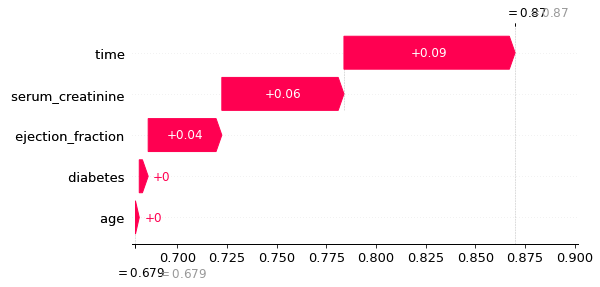

In [32]:
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[0], shap_values_test_tn[0], X_test_feat_sel.iloc[index_TN_shap])

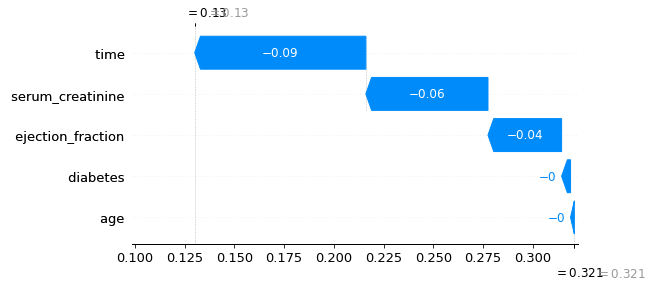

In [33]:
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[1], shap_values_test_tn[1], X_test_feat_sel.iloc[index_TN_shap])

In [34]:
index_TP_shap=2
print(df_X_test_featsel.iloc[index_TP_shap])
print(X_test_feat_sel.iloc[index_TP_shap])
print('Actual Label:', y_test[index_TP_shap])
print('Predicted Label:', y_pred_test[index_TP_shap])
choosen_instance_tp=df_X_test_featsel.iloc[index_TP_shap]

age                  0.636364
ejection_fraction    0.521739
serum_creatinine     1.000000
time                 0.010791
diabetes             0.000000
Name: 2, dtype: float64
age                  75.0
ejection_fraction    38.0
serum_creatinine      2.1
time                 10.0
diabetes              0.0
Name: 10, dtype: float64
Actual Label: 1
Predicted Label: 1


In [35]:
shap_values_test_tp = explainer_test.shap_values(choosen_instance_tp)
shap.force_plot(explainer_test.expected_value[1], shap_values_test_tp[1], X_test_feat_sel.iloc[index_TP_shap])

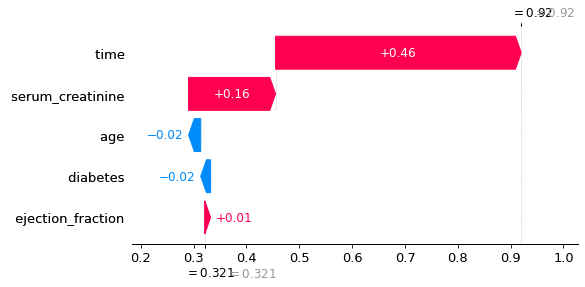

In [36]:
shap.plots._waterfall.waterfall_legacy(explainer_test.expected_value[1], shap_values_test_tp[1], X_test_feat_sel.iloc[index_TP_shap])

In [37]:
index_TN_shap_train = 1
print(df_X_train_featsel.iloc[index_TN_shap_train])
print(X_train_feat_sel.iloc[index_TN_shap_train])
print('Actual Label:', y_train[index_TN_shap_train])
print('Predicted Label:', y_pred_train[index_TN_shap_train])
choosen_instance_tn_train=df_X_train_featsel.iloc[index_TN_shap_train]

age                  0.090909
ejection_fraction    0.222222
serum_creatinine     0.187500
time                 0.824818
diabetes             1.000000
Name: 1, dtype: float64
age                   45.0
ejection_fraction     25.0
serum_creatinine       0.8
time                 230.0
diabetes               1.0
Name: 258, dtype: float64
Actual Label: 0
Predicted Label: 0


In [38]:
shap_values_tn_train = explainer_train.shap_values(choosen_instance_tn_train)
shap.force_plot(explainer_train.expected_value[1], shap_values_tn_train[1], choosen_instance_tn_train)

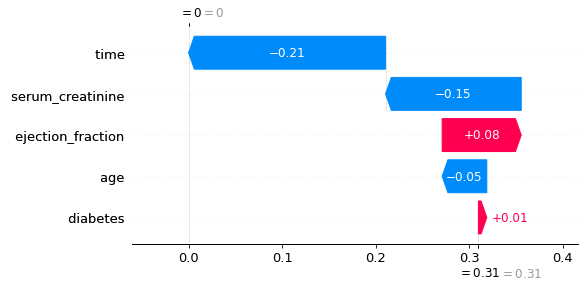

In [39]:
shap.plots._waterfall.waterfall_legacy(explainer_train.expected_value[1], shap_values_tn_train[1], X_train_feat_sel.iloc[index_TN_shap_train])

In [39]:
index_TP_shap_train = 7
print(df_X_train_featsel.iloc[index_TP_shap_train])
print(X_train_feat_sel.iloc[index_TP_shap_train])
print('Actual Label:', y_train[index_TP_shap_train])
print('Predicted Label:', y_pred_train[index_TP_shap_train])
choosen_instance_tp_train=X_train_feat_sel.iloc[index_TP_shap_train]

age                  0.909091
ejection_fraction    0.384615
serum_creatinine     0.179775
time                 0.014599
diabetes             0.000000
Name: 7, dtype: float64
age                   90
ejection_fraction     40
serum_creatinine     2.1
time                   8
diabetes               0
Name: 5, dtype: object
Actual Label: 1
Predicted Label: 1


In [40]:
shap_values_tp_train = explainer_train.shap_values(choosen_instance_tp_train)
shap.force_plot(explainer_train.expected_value[1], shap_values_tp_train[1], X_train_feat_sel.iloc[index_TP_shap_train])

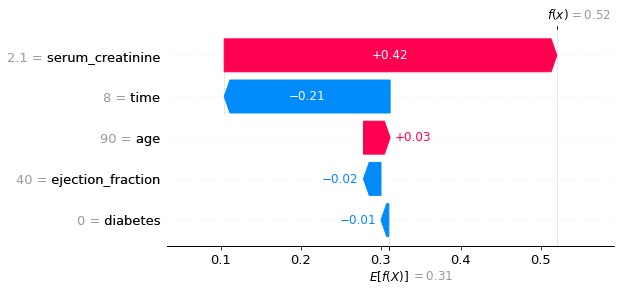

In [41]:
shap.plots._waterfall.waterfall_legacy(explainer_train.expected_value[1], shap_values_tp_train[1], X_train_feat_sel.iloc[index_TP_shap_train])